In [1]:
# import Oracle_Assignment_2 as oa
# import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
# oa.q2_get_mnist_jpg_subset(23634)


In [2]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset



In [3]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.ToTensor(),  # Convert to tensor
])


In [4]:



dataset = datasets.ImageFolder(root="q2_data", transform=transform)

# Split dataset into training and test sets (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:


def evaluate(model, train_loader, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    correct, total = 0, 0
    with torch.no_grad() :
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Train Accuracy: {100 * correct / total:.2f}%")


def train(model, train_loader, criterion, optimizer, device, epochs, test_loader):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  # Update weights using SGD with momentum

            total_loss += loss.item()

        # evaluate(model, train_loader, test_loader, device)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


def metricslearn(model, train_loader, test_loader, device):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


def dataloader_to_numpy(dataloader):
    data_list = []
    labels_list = []

    for images, labels in dataloader:
        images = images.numpy().reshape(images.shape[0], -1)
        data_list.append(images)
        labels_list.append(labels.numpy())

    data_array = np.vstack(data_list)
    labels_array = np.concatenate(labels_list)
    return data_array, labels_array

train_data, train_labels = dataloader_to_numpy(train_loader)
test_data, test_labels = dataloader_to_numpy(test_loader)


def pca(data, k) :
    cov_matrix = np.cov(data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]


    eigenvectors = eigenvectors[:, idx]
    eigenvalues = eigenvalues[idx]
    eigenvecks = eigenvectors[:, :k]
    new_data = np.dot(data, eigenvecks)
    return new_data, eigenvecks




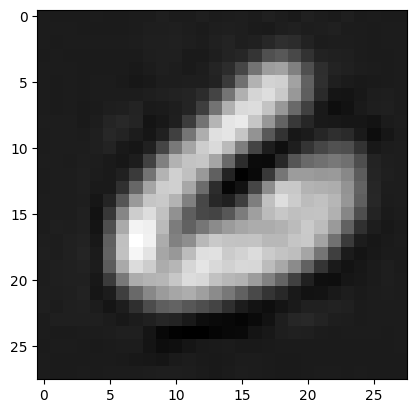

In [6]:


mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
k = 100
train_data_pca, eigenvecks = pca(train_data, k)
test_data_pca = np.dot(test_data, eigenvecks)



# Convert PCA-transformed data to tensors
train_data_pca_tensor = torch.tensor(train_data_pca, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_pca_tensor = torch.tensor(test_data_pca, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset and DataLoader
train_pca_dataset = TensorDataset(train_data_pca_tensor, train_labels_tensor)
test_pca_dataset = TensorDataset(test_data_pca_tensor, test_labels_tensor)

train_pca_loader = DataLoader(train_pca_dataset, batch_size=32, shuffle=True)
test_pca_loader = DataLoader(test_pca_dataset, batch_size=32, shuffle=False)

# Reconstruct a sample image
sample = train_data_pca[10]
reconstructed = np.dot(sample, eigenvecks.T)
reconstructed = (reconstructed * std) + mean
reconstructed = reconstructed.reshape(28, 28)
plt.imshow(reconstructed, cmap="gray")

 


In [ ]:
from kan import *
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = KAN(width=[100,50,20,10],grid =5 ,k=3,seed=42,device=device).to(device)



checkpoint directory created: ./model
saving model version 0.0


In [ ]:

len(train_pca_dataset)
for i in train_pca_dataset:
    print (i)
    break


# train(model,train_data_pca)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(model, train_pca_loader, criterion, optimizer, device, epochs=20, test_loader = test_pca_loader)



model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")




(tensor([-2.0472,  7.9613, -2.2898,  3.4429, -5.2726, -0.3485, -0.4050,  2.1357,
         1.0681,  2.1077, -4.3549, -1.8591, -3.9294,  1.3441,  4.5603,  3.2952,
        -3.4873,  3.1178,  3.6384, -2.1361,  1.6275,  0.9159,  0.6815,  3.2301,
        -1.6479, -1.0020, -0.3372, -0.1730, -1.6207, -1.5034, -3.4637,  1.4142,
         2.0428,  0.4206,  1.7206, -1.0217,  2.6869,  0.2338,  0.5618, -0.1682,
         0.5383,  0.2283, -2.6073,  0.5335,  0.7564,  1.8830, -2.7475,  1.8364,
        -0.1861, -1.5521, -0.3408, -0.4720,  0.6496,  1.8955, -2.9937,  1.9011,
         1.6762, -0.5243, -1.0073, -0.9713, -1.0559,  1.1607,  1.3263, -0.3726,
        -1.7560,  0.6479, -0.4303, -0.6862, -1.3399,  0.1349, -0.6564, -1.2059,
        -1.6218, -1.6516,  0.6206,  2.6700, -1.2187, -1.7361,  0.6729, -1.4730,
         0.5212,  2.0538, -1.4799,  2.4743, -1.2621,  2.5354,  0.3375, -1.1828,
        -0.4938,  0.2449,  0.4972,  0.1283, -0.4411,  0.1275, -0.2815, -0.5866,
         0.2212,  0.8003,  1.2902,  0.2

In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 89.85%
Train Accuracy: 97.79%


In [10]:
mlp_depth_2_accuracy = []
mlp_depth_2_params = []
mlp_depth_3_accuracy = []
mlp_depth_3_params = []

In [11]:
#60042
#log(60042)=11.002
class MLPPCA_depth2_1(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_1 = MLPPCA_depth2_1()


modelMLPPCA_depth2_1 = MLPPCA_depth2_1().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_1.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_1(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_1(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_1.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_1.parameters()))

 

Loss: 1.20638906955719
Loss: 0.6647670865058899
Loss: 0.4454214572906494
Loss: 0.30578529834747314
Loss: 0.21163900196552277
Loss: 0.14618435502052307
Loss: 0.10103955119848251
Loss: 0.07032553851604462
Loss: 0.04969312995672226
Loss: 0.035848215222358704
Loss: 0.026176609098911285
Loss: 0.019392281770706177
Loss: 0.014399940147995949
Loss: 0.01089389342814684
Loss: 0.00817388016730547
Test Accuracy: 95.45%
Train Accuracy: 99.92%


In [12]:
#94218
#log(94218)=11.4533
class MLPPCA_depth2_2(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_3 = MLPPCA_depth2_2()


modelMLPPCA_depth2_3 = MLPPCA_depth2_2().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_3.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_3(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_3(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_3.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_3.parameters()))

Loss: 1.259028434753418
Loss: 0.6786965727806091
Loss: 0.45003604888916016
Loss: 0.3093753755092621
Loss: 0.21154356002807617
Loss: 0.14372067153453827
Loss: 0.09714538604021072
Loss: 0.06725306808948517
Loss: 0.047071244567632675
Loss: 0.03325013071298599
Loss: 0.023979371413588524
Loss: 0.017596229910850525
Loss: 0.012949959374964237
Loss: 0.009588913060724735
Loss: 0.0071768383495509624
Test Accuracy: 95.15%
Train Accuracy: 99.96%


In [13]:

#118666
#log(118666)=11.684
class MLPPCA_depth2_3(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_3, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_3 = MLPPCA_depth2_3()


modelMLPPCA_depth2_3 = MLPPCA_depth2_3().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_3.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_3(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_3(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_3.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_3.parameters()))

 

 

Loss: 1.3631892204284668
Loss: 0.7482692003250122
Loss: 0.5075685977935791
Loss: 0.34887775778770447
Loss: 0.24021679162979126
Loss: 0.16651701927185059
Loss: 0.11424708366394043
Loss: 0.07937150448560715
Loss: 0.05527808517217636
Loss: 0.038668274879455566
Loss: 0.027458714321255684
Loss: 0.019807174801826477
Loss: 0.014404913410544395
Loss: 0.010534807108342648
Loss: 0.007733460981398821
Test Accuracy: 95.70%
Train Accuracy: 99.96%


In [14]:
#94218
#log(94218)=11.4533
class MLPPCA_depth2_4(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_4 = MLPPCA_depth2_4()


modelMLPPCA_depth2_4 = MLPPCA_depth2_4().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_4.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_4(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_4(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_4.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_4.parameters()))

Loss: 1.2603509426116943
Loss: 0.7163689136505127
Loss: 0.479678750038147
Loss: 0.33721724152565
Loss: 0.23491264879703522
Loss: 0.1601710319519043
Loss: 0.10785716772079468
Loss: 0.0731905847787857
Loss: 0.05075164511799812
Loss: 0.03588518127799034
Loss: 0.025730788707733154
Loss: 0.018585825338959694
Loss: 0.0135120190680027
Loss: 0.009827693924307823
Loss: 0.007188238203525543
Test Accuracy: 95.35%
Train Accuracy: 99.96%


In [15]:
#23594
class MLPPCA_depth3_1(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_1 = MLPPCA_depth3_1()


modelMLPPCA_depth3_1 = MLPPCA_depth3_1().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_1.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_1(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_1(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_1.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_1.parameters()))


Loss: 1.8839812278747559
Loss: 1.3678900003433228
Loss: 1.0679810047149658
Loss: 0.8835195302963257
Loss: 0.7262487411499023
Loss: 0.5758704543113708
Loss: 0.45535555481910706
Loss: 0.3610508143901825
Loss: 0.28983527421951294
Loss: 0.23689261078834534
Loss: 0.1940174400806427
Loss: 0.16163477301597595
Loss: 0.13315561413764954
Loss: 0.11079469323158264
Loss: 0.09112150222063065
Test Accuracy: 93.55%
Train Accuracy: 97.19%


In [16]:
#67658
class MLPPCA_depth3_2(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_2 = MLPPCA_depth3_2()


modelMLPPCA_depth3_2 = MLPPCA_depth3_2().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_2.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_2(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_2(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_2.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_2.parameters()))


Loss: 6.0457587242126465
Loss: 2.304762363433838
Loss: 1.5267012119293213
Loss: 1.2472262382507324
Loss: 1.0990264415740967
Loss: 0.9906471371650696
Loss: 0.8887795805931091
Loss: 0.7699379324913025
Loss: 0.6199483871459961
Loss: 0.46972423791885376
Loss: 0.344956636428833
Loss: 0.2514827251434326
Loss: 0.1789318174123764
Loss: 0.1278303563594818
Loss: 0.09119119495153427
Test Accuracy: 93.90%
Train Accuracy: 97.54%


In [17]:
#126282
#log(126282)=11.726
class MLPPCA_depth3_3(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_3, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_3 = MLPPCA_depth3_3()


modelMLPPCA_depth3_3 = MLPPCA_depth3_3().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_3.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_3(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_3(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_3.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_3.parameters()))


Loss: 1.3034424781799316
Loss: 0.8206568360328674
Loss: 0.5888219475746155
Loss: 0.43926388025283813
Loss: 0.3316494822502136
Loss: 0.2410881519317627
Loss: 0.17537616193294525
Loss: 0.12699933350086212
Loss: 0.08942919224500656
Loss: 0.062478505074977875
Loss: 0.042142536491155624
Loss: 0.02863227389752865
Loss: 0.020129550248384476
Loss: 0.014389424584805965
Loss: 0.010287024080753326
Test Accuracy: 95.25%
Train Accuracy: 99.95%


In [18]:
#217226
#log(217226)=12.049
class MLPPCA_depth3_4(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_4 = MLPPCA_depth3_4()


modelMLPPCA_depth3_4 = MLPPCA_depth3_4().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_4.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_4(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(15):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_4(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_4.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_4.parameters()))


Loss: 1.6315147876739502
Loss: 0.8906963467597961
Loss: 0.6037805676460266
Loss: 0.4327716529369354
Loss: 0.3207361102104187
Loss: 0.23273414373397827
Loss: 0.16445839405059814
Loss: 0.11584450304508209
Loss: 0.08030608296394348
Loss: 0.05394405871629715
Loss: 0.03616144880652428
Loss: 0.024844929575920105
Loss: 0.017616547644138336
Loss: 0.01263466663658619
Loss: 0.009113460779190063
Test Accuracy: 94.95%
Train Accuracy: 99.95%


In [19]:
# count = 0

# for p in model.parameters():
#     if p.requires_grad:
#       p_count = p.numel()
#       count += p_count

# print("Number of parameters for kan model =", count)
# # print("The time taken to train for kan model =", end1-start1)

# # count = 0

# # for p in mlp_model.parameters():
# #     if p.requires_grad:
# #       p_count = p.numel()
# #       count += p_count

# # print("Number of parameters for mlp model =", count)
# # print("The time taken to train for mlp model =", end2-start2)

In [20]:
# from kan import *
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# new_model = KAN(width=[100,10,20,10],grid =5 ,k=3,seed=42,device=device).to(device)
# count = 0

# for p in new_model.parameters():
#     if p.requires_grad:
#       p_count = p.numel()
#       count += p_count

# print("Number of parameters for kan model =", count)


In [21]:
# from kan import *
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# new_model = KAN(width=[100,50,20,10],grid =5 ,k=3,seed=42,device=device).to(device)
# count = 0

# for p in new_model.parameters():
#     if p.requires_grad:
#       p_count = p.numel()
#       count += p_count

# print("Number of parameters for kan model =", count)


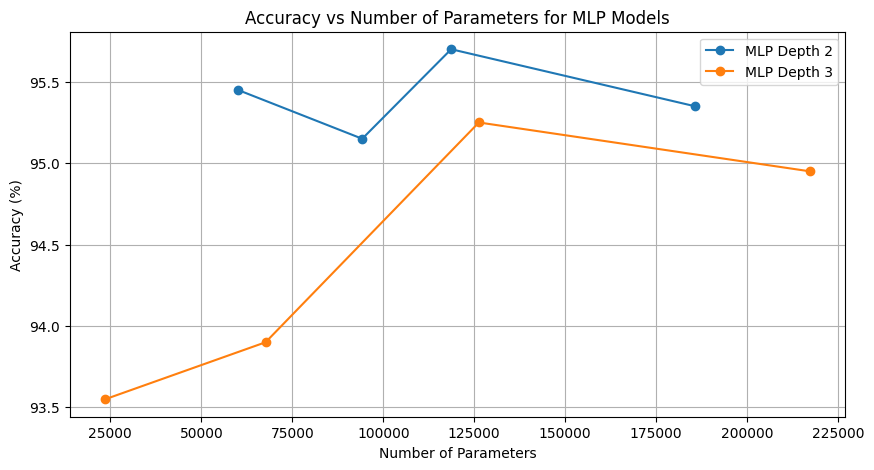

In [22]:
#plot num_params v/s accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlp_depth_2_params, mlp_depth_2_accuracy, label='MLP Depth 2', marker='o')
plt.plot(mlp_depth_3_params, mlp_depth_3_accuracy, label='MLP Depth 3', marker='o')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Parameters for MLP Models')
plt.legend()
plt.grid()
plt.savefig('mlp_accuracy_vs_params.png')
plt.show()